Standarize Audio Input Processing:
1. Sampling Rate (Convert audio files to a common sampling rate, like 22,050 Hz or 16,000 Hz, for consistency)
2. Segment Duration ( Split each audio file into fixed-length segments, such as 3 or 5 seconds, to ensure uniform input size)
3. Spectogram Transformation (Use log-mel spectrograms or Mel-frequency cepstral coefficients (MFCCs) for feature extraction)
4. Normalization (Normalize the spectrogram data across the dataset to have a consistent range. Normalization helps with the generalization across different genres and datasets)

Data Augumentation:
- Varying speed and pitch shifting can hel th emodel to generalize across genres
- Adding variability without changing the genre


Model Specification CNN-LSTM:
 - Convolutional Recurrent Networks (CRNN): A hybrid approach combining CNNs for feature extraction with RNN layers to capture temporal relationships may be beneficial for genre classification.)


Transfer learning:
Traiinig model one by one, finetuning od different datasets


In [ ]:

import kagglehub
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
destination_path = '/content/drive/MyDrive/cs4347/project/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_tids_from_directory(audio_dir):
    """Get track IDs from the mp3s in a directory.
    Parameters
    ----------
    audio_dir : str
        Path to the directory where the audio files are stored.
    Returns
    -------
        A list of track IDs.
    """
    tids = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            tids.extend(int(file[:-4]) for file in files)
    return tids


def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [ ]:
import os
os.chdir('/content/drive/MyDrive/cs4347/project/')
AUDIO_DIR = '/content/drive/MyDrive/cs4347/project/datasets/fma/fma_small/fma_small'


In [ ]:
"""
# Copy the downloaded dataset to your Drive folder
import kagglehub
fma_small_path = kagglehub.dataset_download("imsparsh/fma-free-music-archive-small-medium")
!cp -r {fma_small_path} {destination_path}

print(f"Dataset saved to: {destination_path}")
"""

cp: cannot stat '{fma_small_path}': No such file or directory


NameError: name 'destination_path' is not defined

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Creating spectograms

In [ ]:
def create_spectogram_with_song_filepath(filename):
    y, sr = librosa.load(filename)
    print(sr)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect.T

In [ ]:
def create_spectogram(track_id):
    filename = get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(filename)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect.T

In [ ]:
def plot_spect(track_id):
    spect = create_spectogram(track_id)
    print(spect.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

In [ ]:
filepath = 'tracks.csv'
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])
keep_cols = [('set', 'split'),
('set', 'subset'),('track', 'genre_top')]

df_all = tracks[keep_cols]
df_all = df_all[df_all[('set', 'subset')] == 'small']


df_all['track_id'] = df_all.index
df_all.head()

set            track track_id
             split subset genre_top         
track_id                                    
2         training  small   Hip-Hop        2
5         training  small   Hip-Hop        5
10        training  small       Pop       10
140       training  small      Folk      140
141       training  small      Folk      141

In [ ]:
df_all[('track', 'genre_top')].unique()

array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

In [ ]:
df_all[('set', 'split')].unique()

array(['training', 'validation', 'test'], dtype=object)

In [ ]:
def create_array(df):
    genres = []
    X_spect = np.empty((0, 640, 128))
    count = 0
    #Code skips records in case of errors
    for index, row in df.iterrows():
        try:
            count += 1
            track_id = int(row['track_id'])
            genre = str(row[('track', 'genre_top')])
            spect = create_spectogram(track_id)

            # Normalize for small shape differences
            spect = spect[:640, :]
            X_spect = np.append(X_spect, [spect], axis=0)
            genres.append(dict_genres[genre])
            if count % 100 == 0:
                print("Currently processing: ", count)
        except:
            print("Couldn't process: ", count)
            continue
    y_arr = np.array(genres)
    return X_spect, y_arr

In [ ]:
df_train = df_all[df_all[('set', 'split')]=='training']
df_valid = df_all[df_all[('set', 'split')]=='validation']
df_test = df_all[df_all[('set', 'split')]=='test']

print(df_train.shape, df_valid.shape, df_test.shape)

(6400, 4) (800, 4) (800, 4)


In [ ]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3,
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [ ]:
df_test.head()
df = df_test
genres = []
X_test = np.empty((0, 640, 128))
count = 0
#Code skips records in case of errors
for index, row in df.iterrows():
    try:
        count += 1
        track_id = int(row['track_id'])
        genre = str(row[('track', 'genre_top')])
        spect = create_spectogram(track_id)

        # Normalize for small shape differences
        spect = spect[:640, :]
        X_spect = np.append(X_test, [spect], axis=0)
        genres.append(dict_genres[genre])
        if count % 100 == 0:
            print("Currently processing: ", count)
    except:
        print("Couldn't process: ", count)
        continue
y_test = np.array(genres)



set       split         test
          subset       small
track     genre_top     Rock
track_id                 182
Name: 182, dtype: object


<ipython-input-54-cc91a9b61c31>:11: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  track_id = int(row['track_id'])


set       split                 test
          subset               small
track     genre_top    International
track_id                         704
Name: 704, dtype: object


<ipython-input-54-cc91a9b61c31>:11: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  track_id = int(row['track_id'])


set       split                 test
          subset               small
track     genre_top    International
track_id                         705
Name: 705, dtype: object
set       split                 test
          subset               small
track     genre_top    International
track_id                         706
Name: 706, dtype: object
set       split                 test
          subset               small
track     genre_top    International
track_id                         707
Name: 707, dtype: object
set       split                 test
          subset               small
track     genre_top    International
track_id                         708
Name: 708, dtype: object
set       split                 test
          subset               small
track     genre_top    International
track_id                         709
Name: 709, dtype: object
set       split         test
          subset       small
track     genre_top     Folk
track_id                 890
Name: 890, dtype: o

In [ ]:
X_test, y_test

<ipython-input-38-5acd3f710464>:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  track_id = int(row['track_id'])


Couldn't process:  1
Couldn't process:  2
Couldn't process:  3
Couldn't process:  4
Couldn't process:  5
Couldn't process:  6
Couldn't process:  7
Couldn't process:  8
Couldn't process:  9
Couldn't process:  10
Couldn't process:  11
Couldn't process:  12
Couldn't process:  13
Couldn't process:  14
Couldn't process:  15
Couldn't process:  16
Couldn't process:  17
Couldn't process:  18
Couldn't process:  19
Couldn't process:  20
Couldn't process:  21
Couldn't process:  22
Couldn't process:  23
Couldn't process:  24
Couldn't process:  25
Couldn't process:  26
Couldn't process:  27
Couldn't process:  28
Couldn't process:  29
Couldn't process:  30
Couldn't process:  31
Couldn't process:  32
Couldn't process:  33
Couldn't process:  34
Couldn't process:  35
Couldn't process:  36
Couldn't process:  37
Couldn't process:  38
Couldn't process:  39
Couldn't process:  40
Couldn't process:  41
Couldn't process:  42
Couldn't process:  43
Couldn't process:  44
Couldn't process:  45
Couldn't process:  

In [ ]:
print(X_test.shape, y_test.shape)

In [ ]:
np.savez('test_arr', X_test, y_test)

In [ ]:
def splitDataFrameIntoSmaller(df, chunkSize = 1600):
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

In [ ]:
listDf = splitDataFrameIntoSmaller(df_train)
df1_train = listDf[0]
df2_train = listDf[1]
df3_train = listDf[2]
df4_train = listDf[3]
print(df1_train.shape, df2_train.shape, df3_train.shape, df4_train.shape)

(1600, 4) (1600, 4) (1600, 4) (1600, 4)


In [ ]:
X_train1, y_train1 = create_array(df1_train)

<ipython-input-10-5acd3f710464>:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  track_id = int(row['track_id'])


Couldn't process:  1
Couldn't process:  2
Couldn't process:  3
Couldn't process:  4
Couldn't process:  5
Couldn't process:  6
Couldn't process:  7
Couldn't process:  8
Couldn't process:  9
Couldn't process:  10
Couldn't process:  11
Couldn't process:  12
Couldn't process:  13
Couldn't process:  14
Couldn't process:  15
Couldn't process:  16
Couldn't process:  17
Couldn't process:  18
Couldn't process:  19
Couldn't process:  20
Couldn't process:  21
Couldn't process:  22
Couldn't process:  23
Couldn't process:  24
Couldn't process:  25
Couldn't process:  26
Couldn't process:  27
Couldn't process:  28
Couldn't process:  29
Couldn't process:  30
Couldn't process:  31
Couldn't process:  32
Couldn't process:  33
Couldn't process:  34
Couldn't process:  35
Couldn't process:  36
Couldn't process:  37
Couldn't process:  38
Couldn't process:  39
Couldn't process:  40
Couldn't process:  41
Couldn't process:  42
Couldn't process:  43
Couldn't process:  44
Couldn't process:  45
Couldn't process:  

In [ ]:
X_valid, y_valid = create_array(df_valid)

<ipython-input-10-5acd3f710464>:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  track_id = int(row['track_id'])


Couldn't process:  1
Couldn't process:  2
Couldn't process:  3
Couldn't process:  4
Couldn't process:  5
Couldn't process:  6
Couldn't process:  7
Couldn't process:  8
Couldn't process:  9
Couldn't process:  10
Couldn't process:  11
Couldn't process:  12
Couldn't process:  13
Couldn't process:  14
Couldn't process:  15
Couldn't process:  16
Couldn't process:  17
Couldn't process:  18
Couldn't process:  19
Couldn't process:  20
Couldn't process:  21
Couldn't process:  22
Couldn't process:  23
Couldn't process:  24
Couldn't process:  25
Couldn't process:  26
Couldn't process:  27
Couldn't process:  28
Couldn't process:  29
Couldn't process:  30
Couldn't process:  31
Couldn't process:  32
Couldn't process:  33
Couldn't process:  34
Couldn't process:  35
Couldn't process:  36
Couldn't process:  37
Couldn't process:  38
Couldn't process:  39
Couldn't process:  40
Couldn't process:  41
Couldn't process:  42
Couldn't process:  43
Couldn't process:  44
Couldn't process:  45
Couldn't process:  

In [ ]:
np.savez('valid_arr', X_valid, y_valid)

In [ ]:
np.savez('train1_arr', X_train1, y_train1)

In [ ]:
X_train2, y_train2 = create_array(df2_train)

In [ ]:
np.savez('train2_arr', X_train2, y_train2)

In [ ]:
X_train3, y_train3 = create_array(df3_train)

In [ ]:
print(X_train3.shape, y_train3.shape)

In [ ]:
np.savez('train3_arr', X_train3, y_train3)

In [ ]:
X_train4, y_train4 = create_array(df4_train)

In [ ]:
np.savez('train4_arr', X_train4, y_train4)

In [ ]:
print(X_train4.shape, y_train4.shape)

In [ ]:
npzfile = np.load('/content/drive/MyDrive/cs4347/project/train1_arr.npz')
print(npzfile.files)
X_train1 = npzfile['arr_0']
y_train1 = npzfile['arr_1']
print(X_train1.shape, y_train1.shape)

npzfile = np.load('/content/drive/MyDrive/cs4347/project/train2_arr.npz')
print(npzfile.files)
X_train2 = npzfile['arr_0']
y_train2 = npzfile['arr_1']
print(X_train2.shape, y_train2.shape)

npzfile = np.load('/content/drive/MyDrive/cs4347/project/train3_arr.npz')
print(npzfile.files)
X_train3 = npzfile['arr_0']
y_train3 = npzfile['arr_1']
print(X_train3.shape, y_train3.shape)

npzfile = np.load('/content/drive/MyDrive/cs4347/project/train4_arr.npz')
print(npzfile.files)
X_train4 = npzfile['arr_0']
y_train4 = npzfile['arr_1']
print(X_train4.shape, y_train4.shape)

npzfile = np.load('/content/drive/MyDrive/cs4347/project/valid_arr.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4), axis = 0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis = 0)
print(X_train.shape, y_train.shape)

## Convert y data from scale 0-7
print(np.amin(X_train), np.amax(X_train), np.mean(X_train))
y_train = y_train -1
y_valid = y_valid -1
print(np.amin(y_train), np.amax(y_train), np.mean(y_train))

### Convert the scale of training data
X_train_raw = librosa.core.db_to_power(X_train, ref=1.0)
print(np.amin(X_train_raw), np.amax(X_train_raw), np.mean(X_train_raw))

X_train_log = np.log(X_train_raw)
print(np.amin(X_train_log), np.amax(X_train_log), np.mean(X_train_log))

X_valid_raw = librosa.core.db_to_power(X_valid, ref=1.0)
X_valid_log = np.log(X_valid_raw)

['arr_0', 'arr_1']
(1600, 640, 128) (1600,)
['arr_0', 'arr_1']
(1600, 640, 128) (1600,)
['arr_0', 'arr_1']
(1595, 640, 128) (1595,)
['arr_0', 'arr_1']
(1599, 640, 128) (1599,)
['arr_0', 'arr_1']
(800, 640, 128) (800,)
(6394, 640, 128) (6394,)
-80.0 7.62939453125e-06 -44.05223716874873
0 7 3.500625586487332
1e-08 1.0000017567345547 0.004447216350468748
-18.420680743952364 1.7567330116579157e-06 -10.1434024617799


In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train, y_train = unison_shuffled_copies(X_train_log, y_train)
X_valid, y_valid = unison_shuffled_copies(X_valid_log, y_valid)

print("Shapes are: ", X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

np.savez('shuffled_train', X_train, y_train)
np.savez('shuffled_valid', X_valid, y_valid)

Shapes are:  (6394, 640, 128) (800, 640, 128) (6394,) (800,)


SECTION OF TRAINING

CRNNN model


In [ ]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)


In [ ]:
npzfile_valid = np.load("shuffled_train.npz")
print(npzfile_valid.files)
X_train = npzfile_valid['arr_0']
y_train = npzfile_valid['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [ ]:
npzfile = np.load('shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [ ]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
import tensorflow.keras.utils as utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Loading  datasets converted to npz

Test loading by plotting spectogram

Electronic


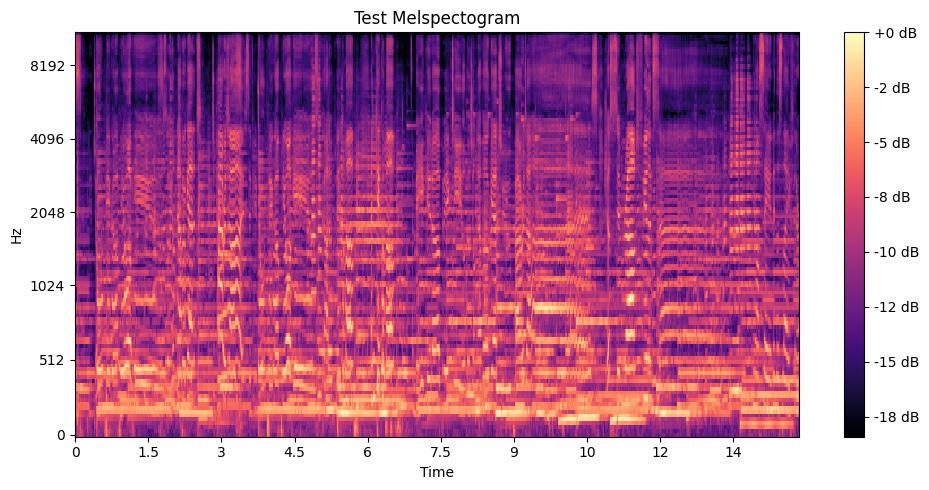

In [ ]:
num = 5300
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

In [ ]:
N_LAYERS = 5
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 28
BATCH_SIZE = 32
LSTM_COUNT = 128
EPOCH_COUNT = 100
NUM_HIDDEN = 64
L2_regularization = 0.001
n_features = X_train.shape[2]
n_time = X_train.shape[1]

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers.schedules import ExponentialDecay


# Conv1D and LSTM combination, which leverages temporal and sequential information in the audio data.

"""
 increasing CONV_FILTER_COUNT.
 By gradually increasing the number of filters, we allow the model to capture
 more complex features in the later layers,
 which can enhance its learning capacity for nuanced genre details.
"""


def conv_recurrent_model_build(model_input, num_classes):
    print('Building model...')
    layer = model_input

    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        layer = Conv1D(
                filters=CONV_FILTER_COUNT*((i+1) * 2),
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)

    ## LSTM Layer
    layer = Bidirectional(LSTM(LSTM_COUNT, return_sequences=False))(layer)
    layer = Dropout(0.4)(layer)

    ## Dense Layer
    layer = Dense(NUM_HIDDEN, activation='relu', kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)

    ## Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)

    initial_learning_rate = 0.001
    lr_schedule = ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=10000,  #usually epochs * steps per epoch)
        decay_rate=0.96,  # Multiplicative factor to decay
        staircase=True  # If True, the learning rate decreases at discrete intervals
    )

    opt = Adam()
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

    print(model.summary())
    return model

In [ ]:
def train_model(x_train, y_train, x_val, y_val):
  n_features = x_train.shape[2]
  input_shape = (None, n_features)
  model_input = Input(input_shape, name='input')

  model = conv_recurrent_model_build(model_input, num_classes=8)

  tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, write_graph=True,
                            write_images=False, embeddings_freq=0,
                              embeddings_metadata=None)
  checkpoint_callback = ModelCheckpoint('./models/crnn/weights.best.keras', monitor='val_accuracy', verbose=1,
                                        save_best_only=True, mode='max')

  reducelr_callback = ReduceLROnPlateau(
              monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01,
              verbose=1
          )
  callbacks_list = [checkpoint_callback, reducelr_callback]

  # Fit the model and get training history.
  print('Training...')
  history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                      validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

  return model, history

In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Train model

In [ ]:

from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=8)
y_val_encoded = to_categorical(y_valid, num_classes=8)


In [ ]:
model, history  = train_model(X_train, y_train_encoded, X_valid, y_val_encoded)

Building model...
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convolution_1 (Conv1D)               │ (None, None, 56)            │          35,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, None, 56)            │             224 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, None, 56)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, None, 56)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 56)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convolution_2 (Conv1D)               │ (None, None, 112)           │          31,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, None, 112)           │             448 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, None, 112)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, None, 112)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 112)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convolution_3 (Conv1D)               │ (None, None, 168)           │          94,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, None, 168)           │             672 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, None, 168)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, None, 168)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 168)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convolution_4 (Conv1D)               │ (None, None, 224)           │         188,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, None, 224)           │             896 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, None, 224)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,103,024 (4.21 MB)

 Trainable params: 1,101,344 (4.20 MB)

 Non-trainable params: 1,680 (6.56 KB)

Streaming output truncated to the last 5000 lines.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
  9/200 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7413 - loss: 0.8471Executing op __inference_one_step_on_iterator_7877 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_7877 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/t

Summary

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


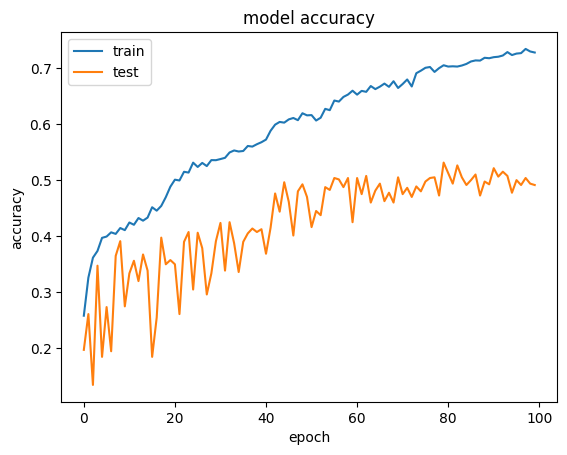

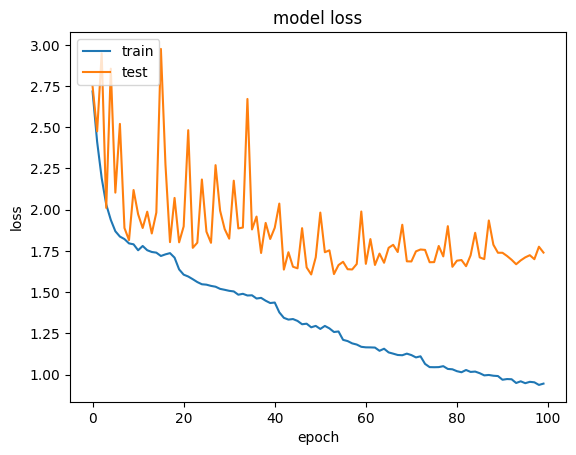

In [ ]:
show_summary_stats(history)

In [ ]:
!pip install modal
!python3 -m modal setup


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.8/485.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.7/425.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 8.0 MB/s eta 0:00:00
  Created wheel for grpclib: filename=grpclib-0.4.7-py3-none-any.whl size=76218 sha256=3b083d0deddb2087591ad1cb27111085c634f0eb167036a9a889b63404f13e4a
  Stored in directory: /root/.cache/pip/wheels/05/c0/1c/3d807409d0c67efeab2949832ba409205b1b6fe03f739ae4c1
Successfully built grpclib
Was not able to launch w

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

NameError: name 'y_valid' is not defined

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

NameError: name 'y_true' is not defined

Connect to test set

In [ ]:
from keras.models import load_model

weights_path = 'models/crnn/weights.best.keras'
model = load_model(weights_path)

npzfile = np.load('valid_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)



['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [ ]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

In [ ]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

In [ ]:
X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
y_test = keras.utils.to_categorical(y_test, num_classes=8)
model.evaluate(X_test, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

In [ ]:
### 8 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

Parallel CNN-LSTM

In [ ]:


import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
import keras.utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline



Load data

In [ ]:
npzfile = np.load('shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

npzfile = np.load('shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)


from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=8)
y_valid = to_categorical(y_valid, num_classes=8)


['arr_0', 'arr_1']
(6394, 640, 128) (6394,)
['arr_0', 'arr_1']
(800, 640, 128) (800,)


Parallel CNN-LSTM model definition

In [ ]:
#PARAMS
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

nb_filters1=16
nb_filters2=32
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize = (3,1)
pool_size_1= (2,2)
pool_size_2= (4,4)
pool_size_3 = (4,2)

dropout_prob = 0.20
dense_size1 = 128
lstm_count = 64
num_units = 120

BATCH_SIZE = 64
EPOCH_COUNT = 50
L2_regularization = 0.001

In [ ]:
import tensorflow as tf

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input

    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)


    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_2)(conv_4)


    conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_5')(pool_4)
    pool_5 = MaxPooling2D(pool_size_2)(conv_5)

    flatten1 = Flatten()(pool_5)
    ### Recurrent Block

    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)

    # Embedding layer

    # Embedding layer
    squeezed = Lambda(lambda x: tf.squeeze(x, axis=-1),
                      output_shape=lambda input_shape: input_shape[:-1])(pool_lstm1)


    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat

    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')

    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)

    model_output = output
    model = Model(model_input, model_output)

#     opt = Adam(lr=0.001)
    opt = RMSprop(learning_rate=0.0005)  # Optimizer
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

    print(model.summary())
    return model

In [ ]:
def train_model(x_train, y_train, x_val, y_val):

    n_frequency = 128
    n_frames = 640
    #reshape and expand dims for conv2d
#     x_train = x_train.reshape(-1, n_frequency, n_frames)
    x_train = np.expand_dims(x_train, axis = -1)

#     x_val = x_val.reshape(-1, n_frequency, n_frames)
    x_val = np.expand_dims(x_val, axis = -1)


    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')

    model = conv_recurrent_model_build(model_input)

#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/parallel/weights.best.keras', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')

    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

Train model

In [ ]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

Building model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 640, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_1 (Conv2D)           │ (None, 638, 128, 16)   │             64 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 319, 64, 16)    │              0 │ conv_1[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_2 (Conv2D)           │ (None, 317, 64, 32)    │          1,568 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 158, 32, 32)    │              0 │ conv_2[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_3 (Conv2D)           │ (None, 156, 32, 64)    │          6,208 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 78, 16, 64)     │              0 │ conv_3[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_4 (Conv2D)           │ (None, 76, 16, 64)     │         12,352 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 19, 4, 64)      │              0 │ conv_4[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_5 (Conv2D)           │ (None, 17, 4, 64)      │         12,352 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool_lstm (MaxPooling2D)  │ (None, 160, 64, 1)     │              0 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 4, 1, 64)       │              0 │ conv_5[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 160, 64)        │              0 │ pool_lstm[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 256)            │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │         49,920 │ lambda[0][0]           │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat (Concatenate)      │ (None, 384)            │              0 │ flatten[0][0],         │
│                           │                        │                │ bidirectional[0][0]    │
├──────────────────────

 Total params: 85,544 (334.16 KB)

 Trainable params: 85,544 (334.16 KB)

 Non-trainable params: 0 (0.00 B)

None
Training...
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.1983 - loss: 2.0441 - val_accuracy: 0.3050 - val_loss: 1.8673 - learning_rate: 5.0000e-04
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 998ms/step - accuracy: 0.3193 - loss: 1.8133 - val_accuracy: 0.3375 - val_loss: 1.7739 - learning_rate: 5.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.3626 - loss: 1.7222 - val_accuracy: 0.3925 - val_loss: 1.6941 - learning_rate: 5.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.3852 - loss: 1.6693 - val_accuracy: 0.4137 - val_loss: 1.6265 - learning_rate: 5.0000e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.4038 - loss: 1.6059 - val_accuracy: 0.3875 - val_loss: 1.6645 - learning_rate: 5.0000e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.4161 - loss: 1.5749 - val_accuracy: 0.4225 - val_loss: 1.5936 - learning_rate: 5.0000e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.4310 - loss: 1.5730 - val_accuracy: 0.4100 - val_loss: 1.5889 - learning_rate: 5.0000e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0

In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Stats

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


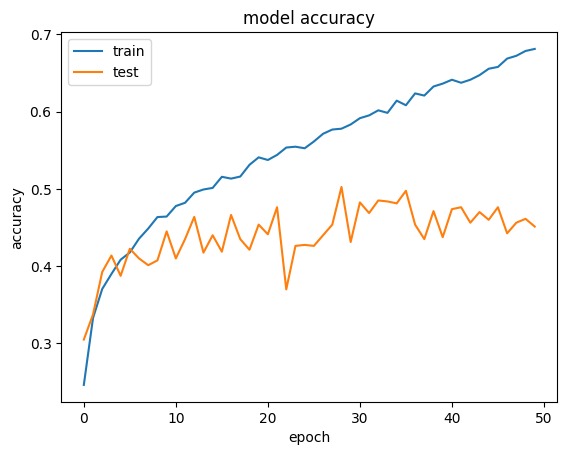

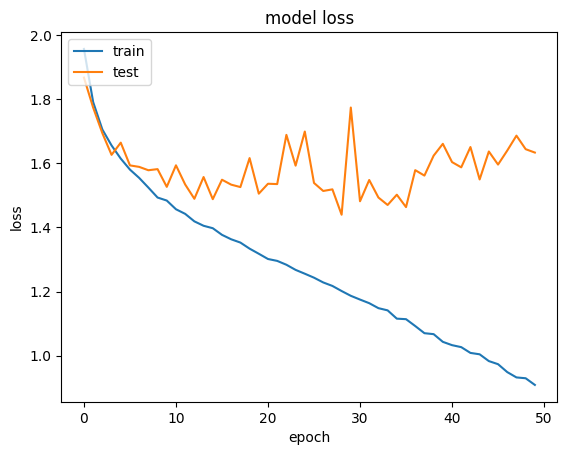

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step


NameError: name 'dict_genres' is not defined

In [ ]:
show_summary_stats(history)

from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
X_valid = np.expand_dims(X_valid, axis = -1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))


from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

Evaluation on test set

In [ ]:
npzfile = np.load('test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

from keras.models import load_model

weights_path = 'models/parallel/weights.best.h5'
#model = load_model(weights_path)

y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)




X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
X_test = np.expand_dims(X_test, axis = -1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');


from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

['arr_0', 'arr_1']
(0, 640, 128) (800,)
-1 6 2.5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


ValueError: math domain error

Loading a trained model on FMA dataset and retraining it on GTZAN dataset

Read data

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from keras import callbacks as cb
import os, json, math, librosa
import librosa.display as dis
import librosa

DATASET_PATH = r'/content/drive/MyDrive/cs4347/project/datasets/gtzan/Data/genres_original/'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

num_mfcc = 13
n_fft = 2048
hop_length = 1024
num_segments = 15


samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

mfcc_list = []
label_list = []

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):
    if dirpath is not DATASET_PATH:
        semantic_label = dirpath.split("/")[-1]
        print("\nProcessing: {}".format(semantic_label))
        for f in filenames:
            file_path = os.path.join(dirpath, f)
            if file_path != '/content/drive/MyDrive/cs4347/project/datasets/gtzan/Data/genres_original/jazz/jazz.00054.wav':
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                for d in range(num_segments):
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        mfcc_list.append(mfcc.tolist())
                        label_list.append(i - 1)

with open(JSON_PATH, "w") as fp:
    json.dump({"mfcc": mfcc_list, "labels": label_list}, fp, indent=4)

print("process finished")

In [ ]:
import sklearn.model_selection as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


DATA_PATH = "data_10.json"


def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def plot_history(history):
    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def predict(model, X, y):
    X = X[np.newaxis, ...]

    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(0.15, 0.15)
X_train.shape

In [ ]:
input_shape = (None, 44, 13, 1)
print(input_shape)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from keras.models import load_model

# Correct paths after confirming their accuracy
#weights_path_parallel = '/content/drive/MyDrive/cs4347/project/models/parallel/weights.best.hdf5'
#weights_path_crnn = '/content/drive/MyDrive/cs4347/project/models/crnn/weights.best.keras'





try:
    #model_parallel = load_model(weights_path_parallel)
    model_crnn = load_model(weights_path_crnn)
    print("Models loaded successfully.")
except Exception as e:
    print(f"An error occurred: {e}")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Models loaded successfully.


In [ ]:
model_crnn.save('/content/drive/MyDrive/cs4347/project/models/crnn/crnn_model.h5')

In [ ]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

names = ['retrained_parallel', 'retrained_crnn']
dir_names = ['parallel', 'crnn']

for i, model in enumerate([model_parallel, model_crnn]):
  new_input = Input(shape=input_shape)
  base_layers = model.layers[-1](new_input)  # Skip the first layer and use the rest

  # Add new top layers
  x = GlobalAveragePooling2D()(base_layers)
  x = Dense(1024, activation='relu')(x)
  new_output = Dense(new_num_classes, activation='softmax')(x)  # new_num_classes is the number of your new classes

  # Create a new model
  new_model = Model(inputs=new_input, outputs=new_output)

  # Optionally, freeze layers from the pre-trained model
  for layer in new_model.layers[:-3]:  # Adjust according to your model structure
      layer.trainable = False

  new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  # Train the model on the new data
  new_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
  new_model.save(f'/content/drive/MyDrive/cs4347/project/models/{dir_names[i]}/{names[i]}.h5')  # Save your model with 10 genres


In [ ]:
!pip install tensorflow  # If not already installed
!pip install onnx onnxruntime  # For ONNX and its runtime
!pip install tf2onnx  # For the conversion tool


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 6.1 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade tf2onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompa

In [ ]:
import tensorflow as tf
import tf2onnx
import onnx
from tensorflow import keras
from keras.models import load_model

onnx_models_path = ['/content/drive/MyDrive/cs4347/project/models/rnn_onnx.onnx', '/content/drive/MyDrive/cs4347/project/models/parallel_onnx.onnx']
#trained_models = [model_crnn, model_parallel]

#for model in trained_models:
input_shape = (None, 640, 128)
input_signature = [tf.TensorSpec([None, 640, 128], tf.float32, name="input")]

#model_crnn = load_model('/content/drive/MyDrive/cs4347/project/models/parallel/weights.best.h5')
# Convert the model to ONNX format using the defined input signature
onnx_model, external_tensor_storage = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=13)

# Save the ONNX model to a file
onnx.save(onnx_model, '/content/drive/MyDrive/cs4347/project/models/paralell_onnx.onnx')
